## 순환 신경망의 고급 사용법
* **순환 드롭아웃(recurrent dropout)**: 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용한다.
* **스태킹 순환 층(stacking recurrent layer)**: 네트워크의 표현 능뎍(representational power)을 증가시킨다(그 대신 계산 비용이 많이 든다)
* **양방향 순환 층(bidirectional recurrent layer)**: 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킨다.

### 기온 예측 문제
* https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [4]:
import os

DATA_PATH = os.path.join(os.environ['DEV_PATH'], 'datasets')

In [17]:
fname = os.path.join(DATA_PATH, 'jena_climate/jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [24]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

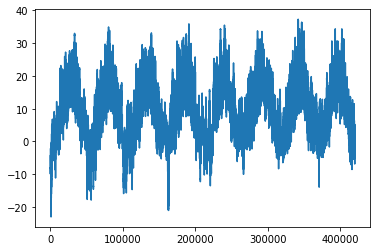

In [27]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

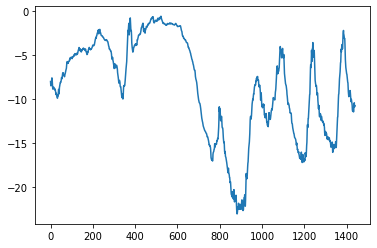

In [28]:
plt.plot(range(1440), temp[:1440])

In [29]:
import pandas as pd

df_jena = pd.read_csv(os.path.join(DATA_PATH, 'jena_climate/jena_climate_2009_2016.csv'))
df_jena

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


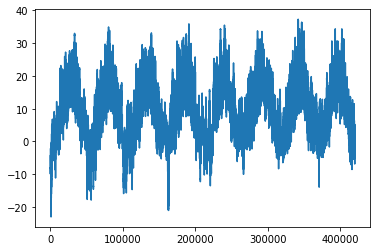

In [30]:
import matplotlib.pyplot as plt

temp = df_jena['T (degC)']
plt.plot(range(len(temp)), temp)

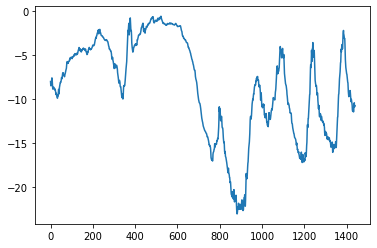

In [31]:
plt.plot(range(1440), temp.iloc[:1440])

### 데이터 준비
* lookback 타임스텝(하나의 타임스텝은 10분)만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링한다.
* 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측
    * lookback = 1440: 10일전 데이터로 돌아간다.
    * steps = 6: 1시간마다 데이터 포인트 하나를 샘플링한다.
    * delay = 144: 24시간이 지난 데이터가 타깃이 된다.
* 신경망에 주입할 수 있는 형태로 데이터를 전처리한다. 데이터가 이미 수지형이므로 추가적인 벡터화가 필요하지 않다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다르다. 각 시계을 틓성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾼다.
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터(generator)를 만든다. 이 데이터셋에 있는 샘플은 중복이 많다. 모든 샘플을 각기 메도리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용하여 그때그때 배치를 만든다.

In [32]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [33]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [34]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback, delay=delay,
    min_index=0, max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 상식 수춘의 기준점
* 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있다.
* 지금으로부터 24시간 후 온도른 지금과 동일하다고 예측하는 것이다.

In [35]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [37]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

### 기본적인 머신 러닝 방법
* 머신 러닝 모델을 시도하기 전에 상식 수준의 기준점을 세워 놓았다.
* 비슷하게 RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단하고 손쉽게 만들 수 있는 머신 러닝 모델(야를 들어 소규모의 완전 연결 네트워크)을 만저 만드는 것이 좋다.

In [39]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20


C:\Users\posky\AppData\Local\Temp\ipykernel_17620\182595232.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


500/500 [==============================] - 8s 13ms/step - loss: 1.6657 - val_loss: 1.1146
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 0.5996 - val_loss: 0.3555
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3169 - val_loss: 0.3362
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2764 - val_loss: 0.2985
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2590 - val_loss: 0.3226
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2471 - val_loss: 0.3234
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2410 - val_loss: 0.3438
Epoch 8/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2343 - val_loss: 0.3309
Epoch 9/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2290 - val_loss: 0.3096
Epoch 10/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2264 - val_loss: 0.3219


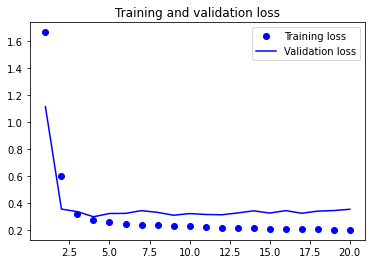

In [40]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 첫 번째 순환 신경망
* 앞선 모델을 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개령을 잃어버렸다.

In [41]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20


C:\Users\posky\AppData\Local\Temp\ipykernel_17620\582558350.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


500/500 [==============================] - 12s 20ms/step - loss: 0.3145 - val_loss: 0.2670
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2847 - val_loss: 0.2698
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2778 - val_loss: 0.2721
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2735 - val_loss: 0.2616
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2702 - val_loss: 0.2612
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2669 - val_loss: 0.2621
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2641 - val_loss: 0.2627
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2591 - val_loss: 0.2649
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2556 - val_loss: 0.2649
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2505 - val_loss: 0.2

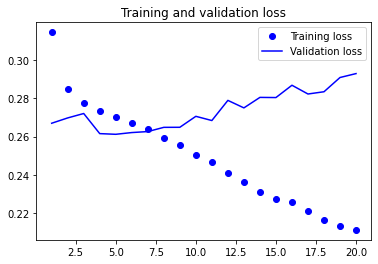

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기
* 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 도랫동안 알려졌다.
* 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크(당일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용해야 한다.

In [44]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(
    32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])
))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/40


C:\Users\posky\AppData\Local\Temp\ipykernel_17620\23704463.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


500/500 [==============================] - 269s 535ms/step - loss: 0.3244 - val_loss: 0.2834
Epoch 2/40
500/500 [==============================] - 265s 531ms/step - loss: 0.3050 - val_loss: 0.2727
Epoch 3/40
500/500 [==============================] - 263s 526ms/step - loss: 0.2987 - val_loss: 0.2710
Epoch 4/40
500/500 [==============================] - 267s 533ms/step - loss: 0.2933 - val_loss: 0.2672
Epoch 5/40
500/500 [==============================] - 268s 536ms/step - loss: 0.2882 - val_loss: 0.2682
Epoch 6/40
500/500 [==============================] - 269s 538ms/step - loss: 0.2846 - val_loss: 0.2744
Epoch 7/40
500/500 [==============================] - 270s 540ms/step - loss: 0.2812 - val_loss: 0.2704
Epoch 8/40
500/500 [==============================] - 266s 532ms/step - loss: 0.2775 - val_loss: 0.2722
Epoch 9/40
500/500 [==============================] - 268s 536ms/step - loss: 0.2744 - val_loss: 0.2746
Epoch 10/40
500/500 [==============================] - 265s 531ms/step - lo

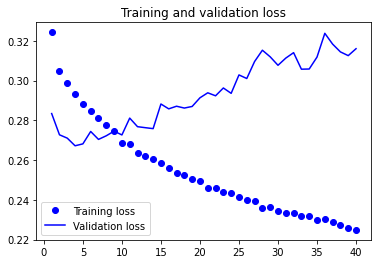

In [45]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 스태킹 순환 층
* (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다 가정하고) 과대적합이 일어날 때까지 네트워크의 용량을 늘리는 것이 좋다.
* 순환 층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법이다.

In [47]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(
    32,
    dropout=0.1,
    recurrent_dropout=0.5,
    return_sequences=True,
    input_shape=(None, float_data.shape[-1])
))
model.add(layers.GRU(
    64,
    activation='relu', 
    dropout=0.1,
    recurrent_dropout=0.5
))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/40


C:\Users\posky\AppData\Local\Temp\ipykernel_17620\2951249834.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


500/500 [==============================] - 582s 1s/step - loss: 0.3211 - val_loss: 0.2844
Epoch 2/40
500/500 [==============================] - 590s 1s/step - loss: 0.3046 - val_loss: 0.2776
Epoch 3/40
500/500 [==============================] - 619s 1s/step - loss: 0.2935 - val_loss: 0.2958
Epoch 4/40
500/500 [==============================] - 580s 1s/step - loss: 0.2845 - val_loss: 0.2700
Epoch 5/40
500/500 [==============================] - 582s 1s/step - loss: 0.2769 - val_loss: 0.2722
Epoch 6/40
500/500 [==============================] - 583s 1s/step - loss: 0.2726 - val_loss: 0.2851
Epoch 7/40
500/500 [==============================] - 758s 2s/step - loss: 0.2686 - val_loss: 0.2754
Epoch 8/40
500/500 [==============================] - 882s 2s/step - loss: 0.2640 - val_loss: 0.2862
Epoch 9/40
500/500 [==============================] - 582s 1s/step - loss: 0.2589 - val_loss: 0.2718
Epoch 10/40
500/500 [==============================] - 858s 2s/step - loss: 0.2547 - val_loss: 0.2816


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있다. 하지만 적지 않은 계산 비용이 추가된다.
* 층을 추가한 만큼 도움이 되지 않았으므로, 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있다.

### 양방향 RNN 사용하기
* **양방향 RNN(bidirectional RNN)**
* 양방향 RNN은 RNN의 한 변종이고 특정 작업에서 기본 RNN보다 훨씬 좋은 성능을 낸다.

In [ ]:
from keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features
)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

* 양방향 RNN은 입력 시퀀스를 양쪽 방향으로 바라보기 때문에 드러나지 않은 다양한 표현을 얻어 시간 순서대로 춰리할 때 놓칠 수 있는 패턴을 잡아낸다.

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])
))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_stpes=val_steps
)

* 이 네트워크는 일반 GRU 층과 비슷한 성능을 낸다.
* 모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 온다.
* 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 때문이다.

### 더 나아가서
* 스태킹한 각 순환 층의 유닛 수를 조정한다. 기즘 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것이다.
* RMSprop 옵티마지어가 사용한 학습률을 조정한다.
* GRU 대신 LSTM층을 사용한다.
* 순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용한다. 즉 유닛 수가 많은 Dense 층 한개 또는 여러 개의 Dense 층을 스태킹한다.
* 최종적으로 (검증 MAE 기준으로 보았을 때) 최선의 모델을 테스트 세트에서 확인해야 한다. 이를 잊으면 검증 세트에 과대적합된 네트워크 그조를 만들게 될 것이다.

### 정리
* 새로운 문제를 해결할 때는 선택한 지표에서 상식 수준의 기준점을 설정하는 것이 좋다. 기준점을 가지고 있지 않으면 실제로 향상되었는지 알 수 없다.
* 계산 비용을 추가할지 판단하기 위해서 비용이 비싼 모델 전에 간단한 모델을 시도한다.
* 시간 순서가 중요한 데이터가 있다면 순환 층이 적합하다. 시계열 데이터를 펼쳐서 쳐리하는 모델의 성능을 쉽게 앞지를 것이다.
* 순환 네트워크에 드롭아웃을 사용하려면 타임스텝 동안 일정한 드롭아웃 마스크와 순환 드롭아웃 마스크를 사용해야 한다. 둘 다 케라스 순환 층에 포함되어 있다. 순환 층에 있는 dropout과 recurrent_dropout 개개변수를 사용하면 된다.
* 스태킹 RNN은 단일 RNN 층보다 더 강력한 표현 능력을 제공한다. 하지만 계산 비용이 많이 들기 때문에 항상 시도할 가제가 있지는 않다. (기계 번역 같은) 복잡한 문제에서 확실히 도움이 되지만 작고 간단한 문제에서는 항상 그렇지 않다.
* 양쪽 방향으로 시퀀스를 바라보는 양방향 RNN은 자연어 칱리 문제에 유용하다. 하지만 최근 정보가 오래된 것보다 훤씬 의미 있는 시퀀스 데이터에는 잘 작동하지 않는다.